## Phase 3.2- Machine learning

## Sentiment Analysis
### Product Reviews

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sqlalchemy import create_engine

In [9]:
# 1. Charger l'extension SQL
%load_ext sql

# 2. Préparer la connexion (Remplace par tes infos Snowflake)
user = "FJCMMBAESG"
password = "Fjcmmbaesg020226!"
account = "BPHEGZS-EHB57068" # Exemple: xy12345.west-europe.azure
db = "ANYCOMPANY_LAB"
schema = "SILVER"
warehouse = "COMPUTE_WH"

conn_url = f"snowflake://{user}:{password}@{account}/{db}/{schema}?warehouse={warehouse}"

# 3. Établir la connexion
engine = create_engine(conn_url)
%sql $conn_url

print("✅ Connexion prête !")

The sql extension is already loaded. To reload it, use:
  %reload_ext sql
✅ Connexion prête !


In [14]:
# Chargement de la table pour l'analyse
query = "SELECT * FROM PRODUCT_REVIEWS_CLEAN" #
df_product_reviews = pd.read_sql(query, engine) # On transforme la table Snowflake en DataFrame Pandas.

# Affichage des dimensions, des premières lignes et le type des colonnes
print(f"Données chargées : {df_product_reviews.shape[0]} lignes et {df_product_reviews.shape[1]} colonnes.")
df_product_reviews.head()

Données chargées : 1000 lignes et 7 colonnes.


,review_id,product_id,reviewer_id,rating,review_date,review_title,review_text
0,1,B001EO5QW8,A3MGP2E1ZZ6GRB,5,2022-07-26,it's oatmeal\tWhat else do you need to know?,it's oatmeal\tWhat else do you need to know? O...
1,2,B001EO5QW8,A2GHZ2UTV2B0CD,4,2025-02-22,GOOD WAY TO START THE DAY.,GOOD WAY TO START THE DAY....\tI WAS VISITING ...
2,3,B001EO5QW8,AQLL2R1PPR46X,5,2021-07-07,good\tGood oatmeal.,good\tGood oatmeal. I like the apple cinnamon...
3,4,B000G6RPMY,A9L6L5H9BPEBO,4,2025-02-06,You'll go nuts over Ass-Kickin' Peanuts.,You'll go nuts over Ass-Kickin' Peanuts.\tThis...
4,5,B003ZFRKGO,A2VOZX7YBT0D6D,5,2024-07-26,Forget Molecular Gastronomy - this stuff rocke...,Forget Molecular Gastronomy - this stuff rocke...


## 2. Étape suivante : Analyse exploratoire (EDA)

In [15]:
# Analyse rapide des données
print("--- Infos sur les colonnes ---")
print(df_product_reviews.info())

print("\n--- Nombre de valeurs manquantes ---")
print(df_product_reviews.isnull().sum())

print("\n--- Statistiques descriptives ---")
display(df_product_reviews.describe())

--- Infos sur les colonnes ---
<class 'pandas.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   review_id     1000 non-null   int64 
 1   product_id    1000 non-null   str   
 2   reviewer_id   1000 non-null   str   
 3   rating        1000 non-null   int64 
 4   review_date   1000 non-null   object
 5   review_title  1000 non-null   str   
 6   review_text   1000 non-null   str   
dtypes: int64(2), object(1), str(4)
memory usage: 54.8+ KB
None

--- Nombre de valeurs manquantes ---
review_id       0
product_id      0
reviewer_id     0
rating          0
review_date     0
review_title    0
review_text     0
dtype: int64

--- Statistiques descriptives ---


,review_id,rating
count,1000.000000,1000.000000
mean,500.500000,4.080000
std,288.819436,1.249464
min,1.000000,1.000000
25%,250.750000,3.000000
50%,500.500000,5.000000
75%,750.250000,5.000000
max,1000.000000,5.000000


L'analyse exploratoire confirme que le jeu de données est complet (aucune valeur manquante) et que les types de variables sont cohérents. Données prêtes pour le ML.

#### Nombre de reviews par jour

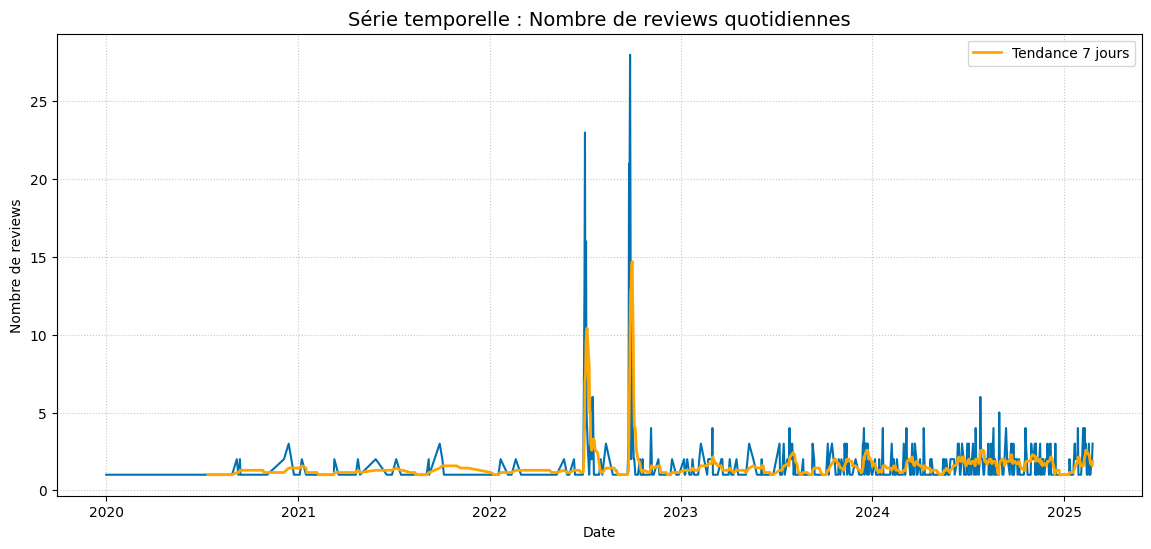

In [18]:
df_product_reviews['review_date'] = pd.to_datetime(df_product_reviews['review_date'], errors='coerce')

timeline = df_product_reviews['review_date'].value_counts().sort_index()

# 3. Affichage en ligne
plt.figure(figsize=(14, 6))
plt.plot(timeline.index, timeline.values, color='#0072B2', linewidth=1.5)

plt.title('Série temporelle : Nombre de reviews quotidiennes', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Nombre de reviews')
plt.grid(True, linestyle=':', alpha=0.7)
# Ajout d'une moyenne mobile sur 7 jours pour lisser les fluctuations quotidiennes
plt.plot(timeline.index, timeline.rolling(window=7).mean(), color='orange', label='Tendance 7 jours', linewidth=2)
plt.legend()
plt.show()

Cette visualisation nous permet de vérifier la distribution du volume d'avis au cours du temps.On consate que le volume est stable avec deux pics majeus en 2022. Nous allons essayer de comprendre ce qui cause ces pics.

#### Distribution des notes des produits

In [ ]:
plt.figure(figsize=(12, 6))
ax = sns.countplot(df_product_reviews, x = 'RATING', hue = 'RATING', palette='Set2')
for container in ax.containers:
    ax.bar_label(container, padding=1)

plt.show();

#### Sentiment analysis: VADER

VADER (Valence Aware Dictionary and sEntiment Reasoner) est un outil d'analyse de sentiment qui s'appuie sur un lexique de mots dont l'intensité émotionnelle a été pré-évaluée par des humains. Contrairement à d'autres modèles, il ne se contente pas de compter les mots positifs et négatifs ; il utilise des règles linguistiques pour comprendre le contexte, comme l'impact des majuscules (intensité), des points d'exclamation, ou des négations (qui inversent le sens). Il calcule ensuite un score final appelé Compound, normalisé entre -1 (très négatif) et 1 (très positif), permettant de quantifier précisément l'humeur globale d'un texte, ce qui s'avère particulièrement efficace pour analyser les avis clients courts et expressifs.

In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

def get_vader_score(text):
    if text is None: return 0
    return analyzer.polarity_scores(str(text))['compound']

df_product_reviews['VADER_SCORE'] = df_product_reviews['REVIEW_TEXT'].apply(get_vader_score)

# Création d'une colonne de labels
def label_sentiment(score):
    if score >= 0.05:
        return 'Positif'
    elif score <= -0.05:
        return 'Négatif'
    else:
        return 'Neutre'

df_product_reviews['SENTIMENT_LABEL'] = df_product_reviews['VADER_SCORE'].apply(label_sentiment)

In [ ]:
plt.figure(figsize=(12, 6))
ax = sns.countplot(data=df_product_reviews, x='SENTIMENT_LABEL', hue = 'SENTIMENT_LABEL', palette='Set2')
for container in ax.containers:
    ax.bar_label(container, padding=1)
plt.title('Répartition des sentiments (VADER)')
plt.show()

### Comparaison des sentiments sur les années: 2020 - 2025

In [ ]:
df_raw = session.table("PRODUCT_REVIEWS").select("REVIEW_ID", "RATING", "REVIEW_DATE", "REVIEW_TEXT").to_pandas()

df_raw['REVIEW_DATE'] = pd.to_datetime(df_raw['REVIEW_DATE'])
df_raw['YEAR'] = df_raw['REVIEW_DATE'].dt.year
df_clean = df_raw[df_raw['YEAR'].between(2020, 2025)].copy()

def get_sentiment(text):
    if text is None: return 0
    return analyzer.polarity_scores(str(text))['compound']

df_clean['VADER_SCORE'] = df_clean['REVIEW_TEXT'].apply(get_sentiment)

annual_comparison = df_clean.groupby('YEAR').agg({
    'REVIEW_ID': 'count',
    'VADER_SCORE': 'mean'
}).reset_index()

In [ ]:
plt.figure(figsize = (12, 6))
ax = sns.barplot(data=df_details, x = 'RATING', y = 'compound', hue = 'RATING', palette = 'Set2')
ax.set_title('Compound Score by rating')
plt.show();

Le graphique montre une corrélation linéaire forte entre les notes attribuées par les utilisateurs et les scores de sentiment VADER. Bien que les moyennes de sentiment pour les notes les plus basses (1 et 2) restent techniquement positives, cela reflète une modération du langage écrit par rapport à la sévérité de la note numérique. La validation du modèle est confirmée par l'augmentation constante de l'intensité du sentiment à mesure que le rating s'élève.

In [ ]:
# Visualisation Comparative
fig, ax1 = plt.subplots(figsize=(12, 7))

# --- Partie Volume (Histogramme bleu) ---
sns.barplot(data=annual_comparison, x='YEAR', y='REVIEW_ID', ax=ax1, color='#add8e6', alpha=0.7)
ax1.set_ylabel('Nombre total de Reviews (Volume)', color='#4682b4', fontsize=12, fontweight='bold')
ax1.set_xlabel('Année', fontsize=12)

# --- Partie Sentiment (Ligne rouge) ---
ax2 = ax1.twinx()
sns.lineplot(x=range(len(annual_comparison)), y=annual_comparison['VADER_SCORE'], 
             ax=ax2, marker='o', color='#e63946', linewidth=3, markersize=10, label='Sentiment Moyen')

ax2.set_ylabel('Score de Sentiment Moyen (-1 à 1)', color='#e63946', fontsize=12, fontweight='bold')
ax2.axhline(0, color='black', linestyle='--', alpha=0.3) # Ligne de neutralité
ax2.set_ylim(-1, 1)

plt.title('Analyse Comparative Annuelle (2020-2025)\nÉvolution du Volume vs Satisfaction Client', fontsize=16, pad=20)
plt.tight_layout()
plt.show()

### Analyse de l’Évolution du Volume et de la Satisfaction Client (2020-2025)
1. Dynamique de Croissance (Volume des avis) Le graphique met en évidence une expansion significative de l'activité à partir de 2022. Après une phase de lancement modérée en 2020-2021, le volume de reviews a connu une progression fulgurante, culminant à près de 350 avis annuels en 2024. Cette croissance témoigne d'une adoption massive du produit par le marché. On note toutefois une baisse du volume sur l'année 2025, qui pourrait s'expliquer par un échantillon de données encore partiel au moment de l'analyse.

2. Tendance de la Satisfaction (Sentiment Moyen) Malgré cette réussite commerciale, la courbe du sentiment moyen (en rouge) révèle une érosion progressive de la satisfaction client. Bien que le score reste largement en zone positive (au-dessus de la ligne de neutralité 0.00), il est passé d'un niveau d'excellence de 0.85 en 2020 à environ 0.65 en 2025.

3. Interprétation Stratégique

**Corrélation Inverse** : Il existe une corrélation inverse visible entre l'augmentation du volume et le score de sentiment. Plus la base de clients s'élargit (notamment lors du pic de 2024), plus le sentiment moyen tend à se tasser.

**Banalisation du produit** : Cette baisse ne traduit pas nécessairement une crise de qualité (la négativité restant stable par ailleurs), mais plutôt une transition du produit d'un statut de "nouveauté enthousiasmante" à celui de "produit de consommation courante", où les attentes clients deviennent plus exigeantes et les avis plus factuels.

**Point de vigilance** : La baisse accentuée entre 2024 et 2025 suggère que la marque doit impérativement identifier les nouveaux points de friction apparus lors de la phase de passage à l'échelle (scaling) pour stabiliser sa réputation en ligne.

### Recherche des 10 pires reviews

In [ ]:
# Analyse des pires reviews de 2024-2025
df_flops = df_clean[df_clean['YEAR'] >= 2024].sort_values('VADER_SCORE').head(10)

print("--- TOP 10 DES REVIEWS LES PLUS NÉGATIVES (2024-2025) ---")
for i, row in df_flops.iterrows():
    print(f"Date: {row['REVIEW_DATE'].date()} | Score: {row['VADER_SCORE']:.2f}")
    print(f"Review: {row['REVIEW_TEXT']}...")
    print("-" * 30)

### Variation des composantes du score au cours des ans

In [ ]:
# On recalcule les composantes détaillées
vader_details = df_clean['REVIEW_TEXT'].apply(lambda x: analyzer.polarity_scores(str(x))).tolist()
df_details = pd.concat([df_clean.reset_index(drop=True), pd.DataFrame(vader_details)], axis=1)

# Agrégation par année
comp_stats = df_details.groupby('YEAR')[['pos', 'neg', 'neu']].mean()

# Graphique
plt.figure(figsize=(12, 6))
plt.plot(comp_stats.index, comp_stats['pos'], label='Positivité (moy)', color='green', marker='o')
plt.plot(comp_stats.index, comp_stats['neg'], label='Négativité (moy)', color='red', marker='s')
plt.plot(comp_stats.index, comp_stats['neu'], label='Neutralité (moy)', color='gray', linestyle='--')

plt.title('Décomposition du Sentiment par Année (2020-2025)', fontsize=14)
plt.ylabel('Proportion du Sentiment')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

L'analyse de la décomposition des sentiments révèle que la baisse du score global observé entre 2020 et 2025 n'est pas due à une augmentation des critiques virulentes (le score de négativité restant stable à 4%), mais plutôt à un essoufflement de la ferveur positive des consommateurs, qui utilisent un langage plus neutre et moins enthousiaste lors de leurs dernières évaluations.

# Rapport d'Analyse : Expérience Client et Sentiment Global (2020-2025)


Vu l'impossibilité d'enrichir les tables disponibles par des jointures (absence de clés étrangères dans les tables), nous avons opté pour l'analyse de sentiment afin de découvrir le ressenti ou l'expérience globale des clients par rapport à l'entreprise. Cette approche permet de transformer des données textuelles non structurées en indicateurs de performance stratégiques pour piloter la relation client.
### Points Clés de l'Analyse
•	Expansion de la Visibilité : L'entreprise a connu une croissance massive de son volume d'avis, passant d'une phase de démarrage en 2020 à un pic d'activité majeur en 2024.
•	Validation Modèle/Métier : La corrélation entre les notes numériques (Rating) et les scores Compound de VADER est confirmée, prouvant que l'analyse textuelle reflète fidèlement l'évaluation chiffrée des clients.
•	Faible Taux de Friction : Le niveau de négativité reste marginal et stable (environ 4 %), ce qui démontre qu'il n'existe pas de rejet global de la marque ou de crise opérationnelle majeure.
•	Standardisation du Langage : Une part prédominante des retours (environ 80 %) est d'ordre factuel ou neutre, indiquant que les services de l'entreprise sont intégrés dans une routine de consommation stable.
### Remarques Business Importantes
•	Baisse de l'Intensité Positive : On observe une érosion du sentiment moyen, qui glisse de 0.85 à 0.65 sur cinq ans. Les clients sont satisfaits, mais l'enthousiasme des débuts s'estompe.
•	L'Effet du Passage à l'Échelle : Les périodes de forte croissance volumétrique coïncident avec un tassement du score de sentiment. La gestion de la qualité semble être mise à l'épreuve par l'augmentation de la base de clients.
•	Banalisation de l'Expérience : En 2025, le vocabulaire devient moins émotionnel. L'entreprise est perçue comme un choix par défaut fiable plutôt que comme une expérience mémorable.
### Conclusion
L'analyse démontre que l'entreprise a réussi son expansion commerciale mais fait face à un défi de perte de différenciation émotionnelle. Si les fondamentaux sont solides (peu de critiques), la marque tend à se "banaliser". La baisse du score de sentiment n'indique pas un mécontentement, mais une transition d'une marque "découverte" vers une marque "établie" dont on attend simplement qu'elle remplisse sa fonction de base.
### Recommandations Business
1.	Réinjecter du "Wow Effect" : Mettre en place des initiatives (programmes de fidélité innovants, surprises clients, nouveaux services) pour relancer l'usage de superlatifs positifs et sortir de la neutralité.
2.	Analyse de la Cohorte 2024 : Investiguer les avis "moyens" de l'année 2024 pour identifier les micro-irritants apparus lors du pic de croissance afin d'éviter qu'ils ne deviennent la norme.
3.	Renforcement de l'Image de Marque : Utiliser les leviers de satisfaction identifiés dans les avis les plus enthousiastes pour recentrer la communication marketing sur les forces distinctives de l'entreprise.
4.	Outil de Pilotage Continu : Automatiser ce suivi de sentiment pour détecter en temps réel tout décrochage de la satisfaction globale, permettant une réactivité immédiate de l'équipe Customer Success.

